In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch
import random
import numpy as np

# Путь к твоей папке с данными
DATA_DIR = '.' 
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))

print(f"Всего строк: {len(train_df)}")


Всего строк: 1785


In [35]:
train_df.head()


,sample_id,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,target_name,target
0,ID1011485656__Dry_Clover_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Clover_g,0.0000
1,ID1011485656__Dry_Dead_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Dead_g,31.9984
2,ID1011485656__Dry_Green_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Green_g,16.2751
3,ID1011485656__Dry_Total_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,Dry_Total_g,48.2735
4,ID1011485656__GDM_g,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,GDM_g,16.2750


In [36]:
train_df.describe()

,Pre_GSHH_NDVI,Height_Ave_cm,target
count,1785.000000,1785.000000,1785.000000
mean,0.657423,7.595985,24.782295
std,0.151972,10.273725,25.823738
min,0.160000,1.000000,0.000000
25%,0.560000,3.000000,4.818200
50%,0.690000,4.000000,18.200000
75%,0.770000,7.000000,35.940600
max,0.910000,70.000000,185.700000


In [37]:


# 2. Группируем данные, чтобы развернуть target_name в столбцы
# Мы сохраняем image_path и метаданные как индексы, а target_name превращаем в колонки
train_wide = train_df.pivot_table(
    index=['image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm'], 
    columns='target_name', 
    values='target'
).reset_index()

# 3. Убираем лишнее имя индекса колонок и приводим названия к удобному виду
train_wide.columns.name = None
train_wide = train_wide.rename(columns={
    'Dry_Clover_g': 'clover',
    'Dry_Dead_g': 'dead',
    'Dry_Green_g': 'green',
    'Dry_Total_g': 'total',
    'GDM_g': 'gdm'
})

# Проверка результата
print(f"Новая форма таблицы: {train_wide.shape}")
train_wide.head()

Новая форма таблицы: (357, 11)


,image_path,Sampling_Date,State,Species,Pre_GSHH_NDVI,Height_Ave_cm,clover,dead,green,total,gdm
0,train/ID1011485656.jpg,2015/9/4,Tas,Ryegrass_Clover,0.62,4.6667,0.0000,31.9984,16.2751,48.2735,16.2750
1,train/ID1012260530.jpg,2015/4/1,NSW,Lucerne,0.55,16.0000,0.0000,0.0000,7.6000,7.6000,7.6000
2,train/ID1025234388.jpg,2015/9/1,WA,SubcloverDalkeith,0.38,1.0000,6.0500,0.0000,0.0000,6.0500,6.0500
3,train/ID1028611175.jpg,2015/5/18,Tas,Ryegrass,0.66,5.0000,0.0000,30.9703,24.2376,55.2079,24.2376
4,train/ID1035947949.jpg,2015/9/11,Tas,Ryegrass,0.54,3.5000,0.4343,23.2239,10.5261,34.1844,10.9605


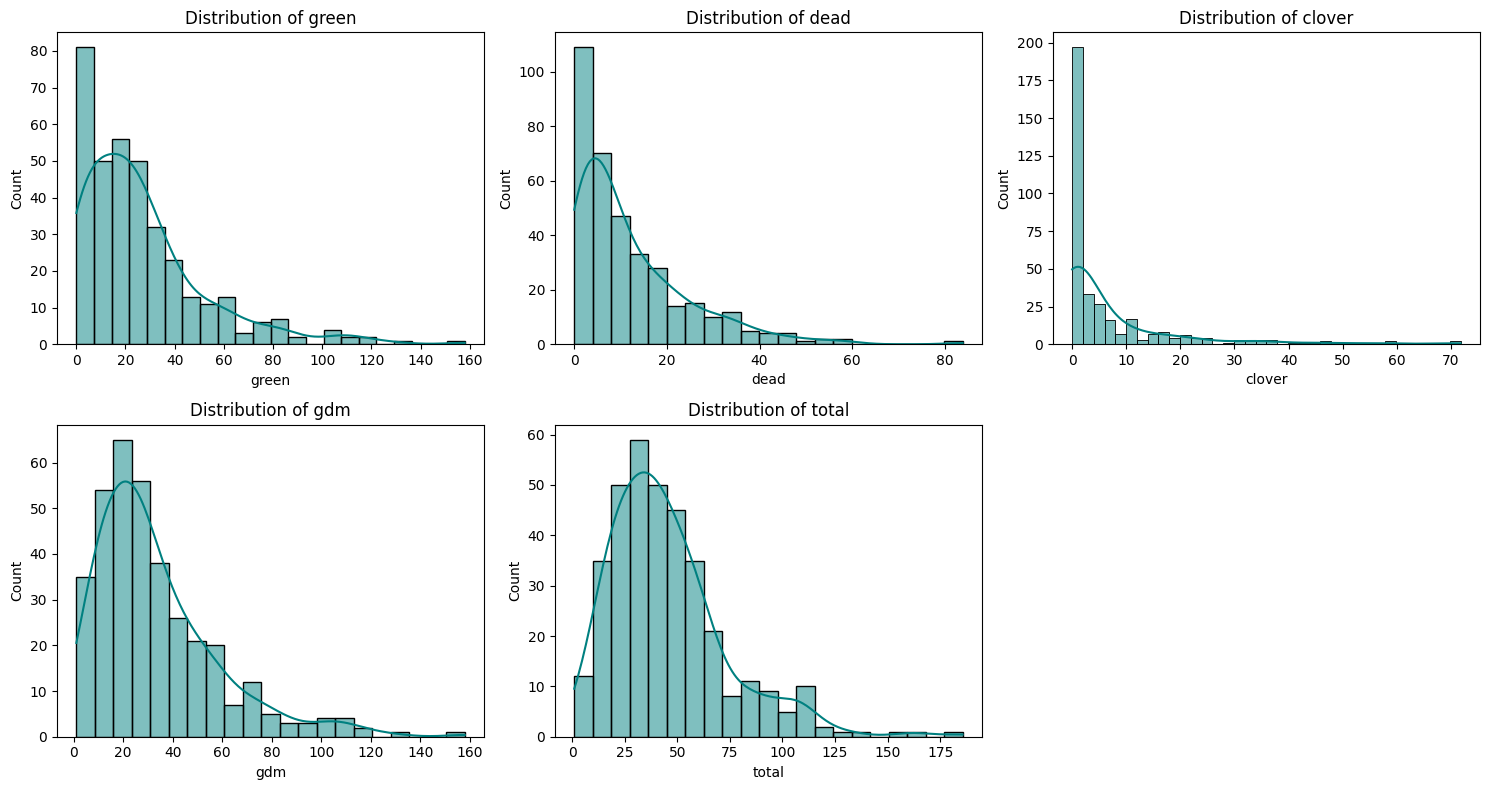

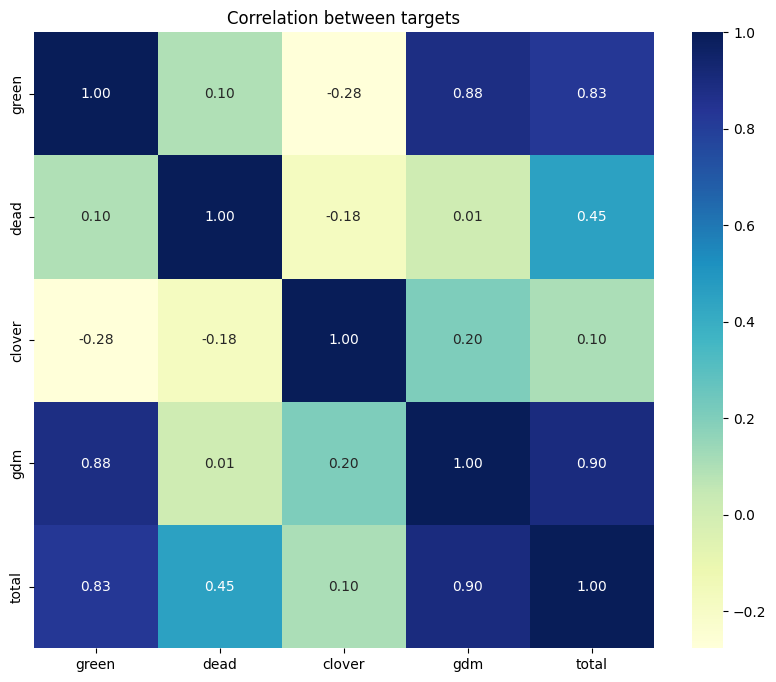

In [38]:


# Список наших целевых переменных
target_cols = ['green', 'dead', 'clover', 'gdm', 'total']

# 1. Построение гистограмм
plt.figure(figsize=(15, 8))
for i, col in enumerate(target_cols):
    plt.subplot(2, 3, i+1)
    sns.histplot(train_wide[col], kde=True, color='teal')
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# 2. Матрица корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(train_wide[target_cols].corr(), annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Correlation between targets")
plt.show()

In [39]:
# Список целевых переменных
target_cols = ['green', 'dead', 'clover', 'gdm', 'total']

print("=== СТАТИСТИКА ПО ТАРГЕТАМ ===")
for col in target_cols:
    stats = train_wide[col].describe()
    skewness = train_wide[col].skew()
    zero_pct = (train_wide[col] == 0).mean() * 100
    
    print(f"\nПараметр: {col.upper()}")
    print(f"  Среднее: {stats['mean']:.2f} | Медиана: {stats['50%']:.2f}")
    print(f"  Мин: {stats['min']:.2f} | Макс: {stats['max']:.2f}")
    print(f"  Стд. откл: {stats['std']:.2f}")
    print(f"  Асимметрия (Skew): {skewness:.2f} (чем выше > 0, тем длиннее хвост справа)")
    print(f"  Процент нулей: {zero_pct:.2f}%")

print("\n=== КОРРЕЛЯЦИЯ С TOTAL ===")
correlations = train_wide[target_cols].corr()['total'].sort_values(ascending=False)
print(correlations)

print("\n=== ПРОВЕРКА СУММЫ (Consistency Check) ===")
# Считаем, насколько сумма частей (green + dead + clover) отличается от total
sum_parts = train_wide['green'] + train_wide['dead'] + train_wide['clover']
diff = (train_wide['total'] - sum_parts).abs()
print(f"  Средняя ошибка суммы: {diff.mean():.4f} г")
print(f"  Макс. ошибка суммы: {diff.max():.4f} г")

=== СТАТИСТИКА ПО ТАРГЕТАМ ===

Параметр: GREEN
  Среднее: 26.62 | Медиана: 20.80
  Мин: 0.00 | Макс: 157.98
  Стд. откл: 25.40
  Асимметрия (Skew): 1.75 (чем выше > 0, тем длиннее хвост справа)
  Процент нулей: 5.04%

Параметр: DEAD
  Среднее: 12.04 | Медиана: 7.98
  Мин: 0.00 | Макс: 83.84
  Стд. откл: 12.40
  Асимметрия (Skew): 1.76 (чем выше > 0, тем длиннее хвост справа)
  Процент нулей: 11.20%

Параметр: CLOVER
  Среднее: 6.65 | Медиана: 1.42
  Мин: 0.00 | Макс: 71.79
  Стд. откл: 12.12
  Асимметрия (Skew): 2.84 (чем выше > 0, тем длиннее хвост справа)
  Процент нулей: 37.82%

Параметр: GDM
  Среднее: 33.27 | Медиана: 27.11
  Мин: 1.04 | Макс: 157.98
  Стд. откл: 24.94
  Асимметрия (Skew): 1.56 (чем выше > 0, тем длиннее хвост справа)
  Процент нулей: 0.00%

Параметр: TOTAL
  Среднее: 45.32 | Медиана: 40.30
  Мин: 1.04 | Макс: 185.70
  Стд. откл: 27.98
  Асимметрия (Skew): 1.43 (чем выше > 0, тем длиннее хвост справа)
  Процент нулей: 0.00%

=== КОРРЕЛЯЦИЯ С TOTAL ===
total     1

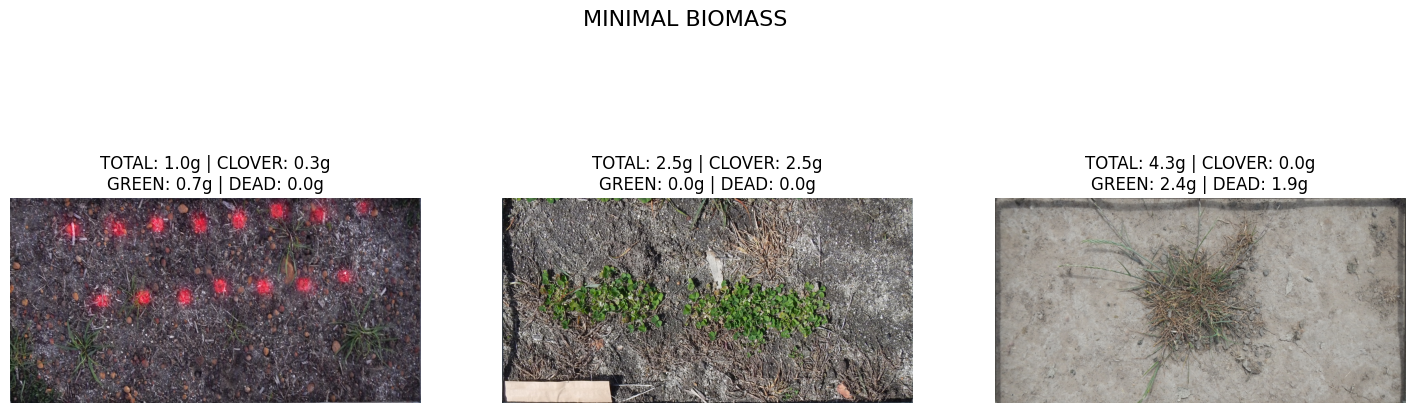

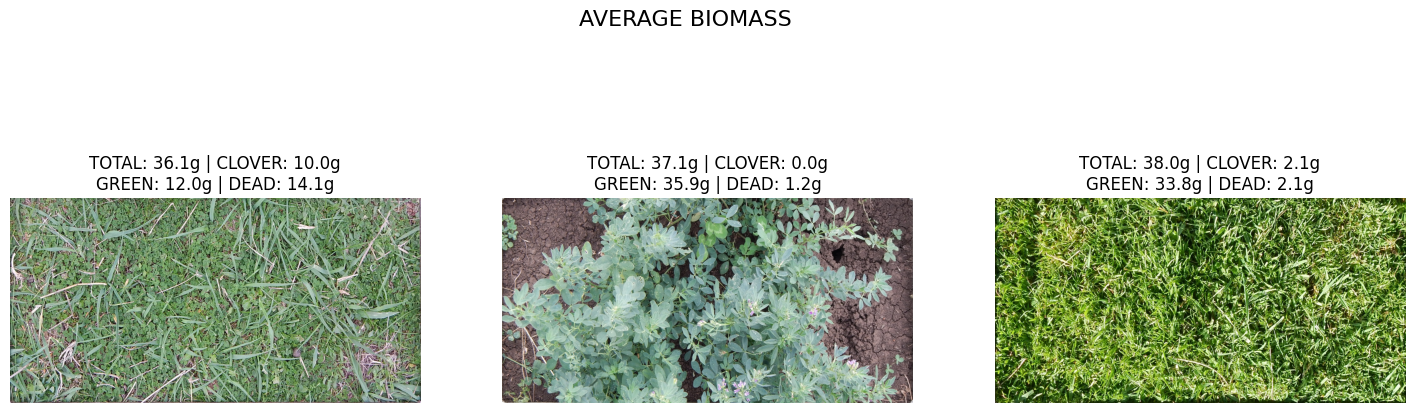

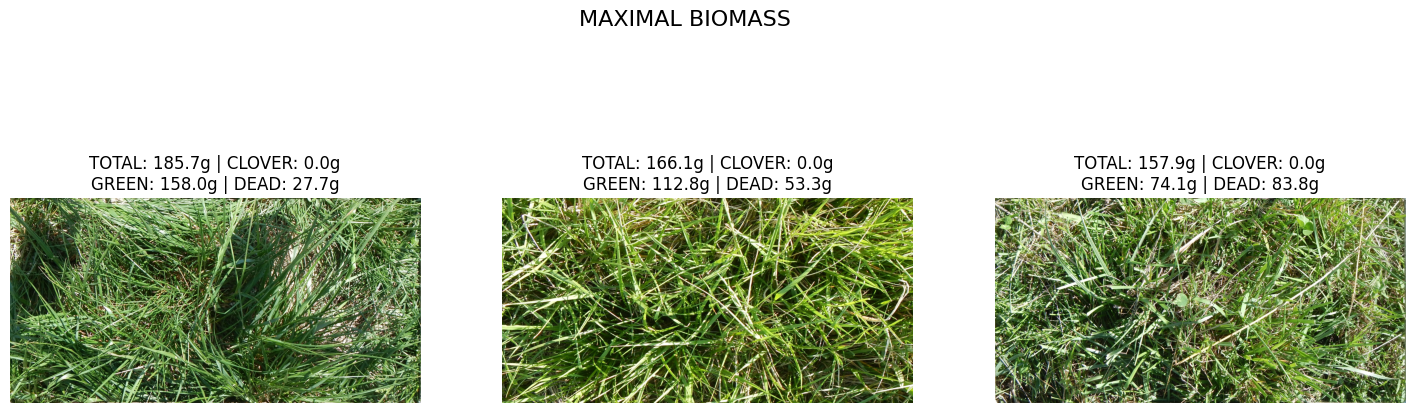

In [40]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images(df, title, count=3):
    plt.figure(figsize=(18, 6))
    for i in range(count):
        row = df.iloc[i]
        # Путь к картинке. Убедись, что расширение .jpg или .png совпадает
        img_path = os.path.join(DATA_DIR, row['image_path'])
        
        img = Image.open(img_path)
        plt.subplot(1, count, i+1)
        plt.imshow(img)
        plt.title(f"TOTAL: {row['total']:.1f}g | CLOVER: {row['clover']:.1f}g\nGREEN: {row['green']:.1f}g | DEAD: {row['dead']:.1f}g")
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

# 1. Самые бедные растительностью
show_images(train_wide.sort_values('total').head(3), "MINIMAL BIOMASS")

# 2. Среднячки
show_images(train_wide[(train_wide['total'] > 35) & (train_wide['total'] < 45)].sample(3), "AVERAGE BIOMASS")

# 3. Самые густые
show_images(train_wide.sort_values('total', ascending=False).head(3), "MAXIMAL BIOMASS")

In [66]:
def seed_everything(seed=42):
    # Базовый Python и переменные окружения
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # для multi-GPU систем
    
    # Делаем вычисления детерминированными (может чуть замедлить обучение)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"Random seed set to: {seed}")



In [67]:
# Вызывай в самом начале кода
seed_everything(26)

Random seed set to: 26


In [68]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# Создаем колонку 'bins' для стратификации (разбиваем total на 10 групп)
train_wide['bins'] = pd.cut(train_wide['total'], bins=10, labels=False)

# Инициализируем K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Добавляем колонку 'fold' в нашу таблицу
train_wide['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(skf.split(train_wide, train_wide['bins'])):
    train_wide.loc[val_idx, 'fold'] = fold

# Проверяем, сколько картинок в каждом фолде
print(train_wide['fold'].value_counts().sort_index())

# Удаляем временную колонку bins
train_wide = train_wide.drop('bins', axis=1)

fold
0    72
1    72
2    71
3    71
4    71
Name: count, dtype: int64


/home/ils0/miniforge3/envs/tatneft/lib/python3.10/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [69]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BiomassDataset(Dataset):
    def __init__(self, df, transform=None, pre_load=True):
        self.df = df
        self.transform = transform
        self.target_cols = ['green', 'dead', 'clover', 'gdm', 'total']
        self.images = []
        
        if pre_load:
            print("Загружаю данные в RAM...")
            for img_path in df['image_path']:
                full_path = os.path.join(DATA_DIR, img_path)
                image = cv2.imread(full_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                # Делаем ресайз сразу при загрузке, чтобы не тратить время потом
                image = cv2.resize(image, (256, 256)) 
                self.images.append(image)
            print("Готово!")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Берем уже готовую картинку из оперативы
        image = self.images[idx]
        targets = self.df.iloc[idx][self.target_cols].values.astype(np.float32)
        
        if self.transform:
            # Аугментации (повороты и т.д.) всё равно делаем на лету, 
            # но это уже гораздо быстрее
            image = self.transform(image=image)['image']
            
        return image, torch.tensor(targets)

# Базовые трансформации (пока просто ресайз и нормализация)
IMG_SIZE = 256 # Начнем с небольшого размера для скорости

transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

In [70]:
import timm
import torch.nn as nn

class BiomassModel(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super().__init__()
        # num_classes=0 убирает стандартный классификатор, оставляя только вектор признаков
        self.backbone = timm.create_model(model_name, pretrained=pretrained, num_classes=0, global_pool='avg')
        num_features = self.backbone.num_features
        
        # Наша "голова" для регрессии
        self.head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 5) # 5 выходов под наши колонки
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Обучение на: {device}")

Обучение на: cuda


In [71]:
from sklearn.metrics import r2_score
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    all_targets = []
    all_preds = []
    val_loss = 0
    
    with torch.no_grad():
        for images, targets in loader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            
            # Считаем MSE на обычных граммах
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            
            all_targets.append(targets.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())
            
    all_targets = np.vstack(all_targets)
    all_preds = np.vstack(all_preds)
    
    avg_loss = val_loss / len(loader)
    
    # Считаем R2
    global_r2 = r2_score(all_targets, all_preds)
    
    # Собираем R2 по каждому компоненту отдельно
    target_names = ['green', 'dead', 'clover', 'gdm', 'total']
    individual_r2 = r2_score(all_targets, all_preds, multioutput='raw_values')
    per_target_r2 = dict(zip(target_names, individual_r2))
    
    return avg_loss, global_r2, per_target_r2

In [ ]:
# Настройки

BATCH_SIZE = 16




fold = 0
train_idx = train_wide[train_wide['fold'] != fold].index
val_idx = train_wide[train_wide['fold'] == fold].index

train_ds = BiomassDataset(train_wide.iloc[train_idx], transform=transforms)
val_ds = BiomassDataset(train_wide.iloc[val_idx], transform=transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)



Загружаю данные в RAM...
Готово!
Загружаю данные в RAM...
Готово!


In [81]:
LR = 1e-4
EPOCHS = 40 # Увеличил, так как с логом можно учить дольше

In [96]:
model = BiomassModel().to(device)
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-5)
criterion = nn.MSELoss()
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Структура для хранения истории
fold_history = {
    'train_loss': [],
    'val_loss': [],
    'val_r2': [],        # Это будет средний (Global)
    'r2_green': [],
    'r2_dead': [],
    'r2_clover': [],
    'r2_total': []
}


print(f"Starting Fold {fold}...")

for epoch in range(EPOCHS):
    # Обучение
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    
    # Валидация
    val_loss, val_r2, per_target_r2 = validate(model, val_loader, criterion, device)
    
    # Сохраняем средний R2
    fold_history['val_r2'].append(val_r2)
    fold_history['train_loss'].append(train_loss)
    fold_history['val_loss'].append(val_loss)
    
    # Сохрiняем каждый таргет отдельно из словаря per_target_r2
    fold_history['r2_green'].append(per_target_r2['green'])
    fold_history['r2_dead'].append(per_target_r2['dead'])
    fold_history['r2_clover'].append(per_target_r2['clover'])
    fold_history['r2_total'].append(per_target_r2['total'])
    
    # И выводим их все в консоль, чтобы видеть прогресс
    print(f"Epoch {epoch+1:02d} | train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f} | R2 Global: {val_r2:.3f}")


Starting Fold 0...
Epoch 01 | train Loss: 1269.76 | Val Loss: 1270.19 | R2 Global: -1.250
Epoch 02 | train Loss: 1197.71 | Val Loss: 1105.39 | R2 Global: -1.013
Epoch 03 | train Loss: 1024.50 | Val Loss: 782.52 | R2 Global: -0.579
Epoch 04 | train Loss: 804.44 | Val Loss: 854.80 | R2 Global: -0.652
Epoch 05 | train Loss: 672.22 | Val Loss: 618.75 | R2 Global: -0.320
Epoch 06 | train Loss: 632.52 | Val Loss: 629.46 | R2 Global: -0.327
Epoch 07 | train Loss: 575.45 | Val Loss: 521.64 | R2 Global: -0.162
Epoch 08 | train Loss: 518.93 | Val Loss: 508.46 | R2 Global: -0.120
Epoch 09 | train Loss: 473.89 | Val Loss: 416.93 | R2 Global: 0.020
Epoch 10 | train Loss: 409.15 | Val Loss: 390.22 | R2 Global: 0.050
Epoch 11 | train Loss: 350.97 | Val Loss: 336.36 | R2 Global: 0.161
Epoch 12 | train Loss: 327.66 | Val Loss: 391.84 | R2 Global: 0.056
Epoch 13 | train Loss: 312.79 | Val Loss: 363.31 | R2 Global: 0.131
Epoch 14 | train Loss: 267.07 | Val Loss: 303.54 | R2 Global: 0.221
Epoch 15 | train

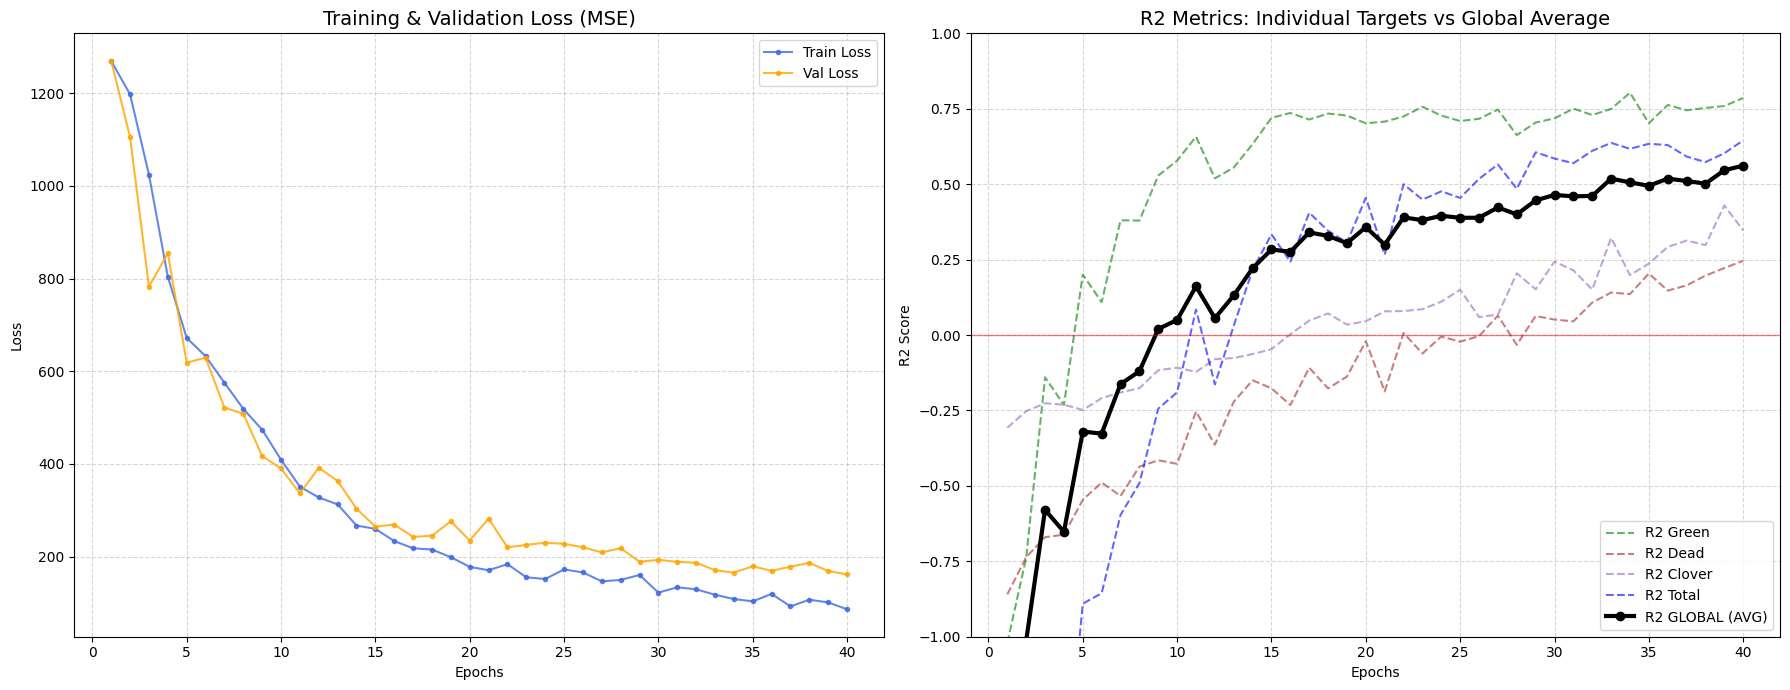

In [97]:
import matplotlib.pyplot as plt

def plot_full_biomass_fold_hostory(fold_hostory):
    epochs = range(1, len(fold_hostory['train_loss']) + 1)
    
    plt.figure(figsize=(18, 7))
    
    # --- ЛЕВЫЙ ГРАФИК: LOSS ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, fold_hostory['train_loss'], '.-', label='Train Loss', color='royalblue', alpha=0.8)
    plt.plot(epochs, fold_hostory['val_loss'], '.-', label='Val Loss', color='orange', alpha=0.8)
    plt.title('Training & Validation Loss (MSE)', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # --- ПРАВЫЙ ГРАФИК: R2 ПО ВСЕМ ТАРГЕТАМ ---
    plt.subplot(1, 2, 2)
    
    # Тонкие линии для каждого параметра
    plt.plot(epochs, fold_hostory['r2_green'], '--', label='R2 Green', color='green', alpha=0.6)
    plt.plot(epochs, fold_hostory['r2_dead'], '--', label='R2 Dead', color='brown', alpha=0.6)
    plt.plot(epochs, fold_hostory['r2_clover'], '--', label='R2 Clover', color='tab:purple', alpha=0.6)
    plt.plot(epochs, fold_hostory['r2_total'], '--', label='R2 Total', color='blue', alpha=0.6)
    
    # Жирная линия для усредненного R2 Global
    plt.plot(epochs, fold_hostory['val_r2'], 'o-', label='R2 GLOBAL (AVG)', color='black', linewidth=3)
    
    # Базовая линия нуля (всё, что ниже — модель просто угадывает)
    plt.axhline(y=0, color='red', linestyle='-', linewidth=1, alpha=0.5)
    
    plt.title('R2 Metrics: Individual Targets vs Global Average', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('R2 Score')
    plt.ylim(-1, 1) # Ограничим, чтобы график не улетал из-за плохих стартовых эпох
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Запускай после завершения обучения:
plot_full_biomass_fold_hostory(fold_history)